In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django

sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

django.db.connection.close()

In [27]:
qids = [
    10366, # MEDLINE UPDATE
    10393, # MEDLINE BACKDATE
    10327, # SCOPUS UPDATE
    10380, # SOPUS BACKDATE
    10326, # WOS UPDATE 2
    9591, # WOS UPDATE 
    10450, # WOS 2 retry
    10448, # WOS 2020 retry,
    8510, # LPH ALL,

]
qs = Query.objects.filter(pk__in=qids)
dids = set(Doc.objects.filter(query__in=qs).values_list('pk',flat=True))


In [28]:
bypy = pd.DataFrame.from_dict(Doc.objects.filter(id__in=dids).values('id','PY','tslug'))


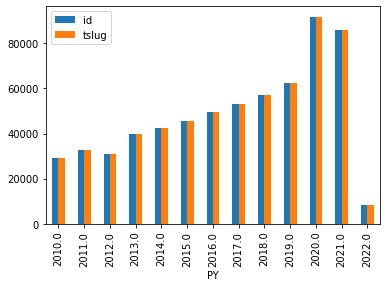

In [29]:
bypy[bypy['PY']>=2010].groupby('PY').count().plot.bar()


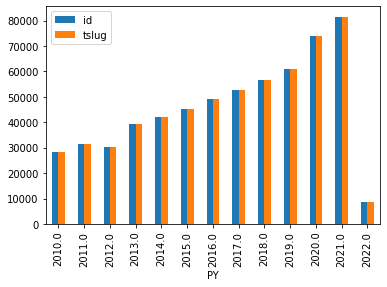

In [30]:
bypy[(bypy['PY']>=2010)].drop_duplicates("tslug").groupby('PY').count().plot.bar()

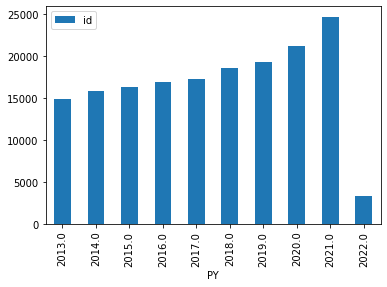

In [31]:
medline_queries = [10366,10393,8421]
qs = Query.objects.filter(pk__in=medline_queries)
dids = set(Doc.objects.filter(query__in=qs).values_list('pk',flat=True))
bypy = pd.DataFrame.from_dict(Doc.objects.filter(id__in=dids).values('id','PY'))
bypy[bypy['PY']>=2013].groupby('PY').count().plot.bar()

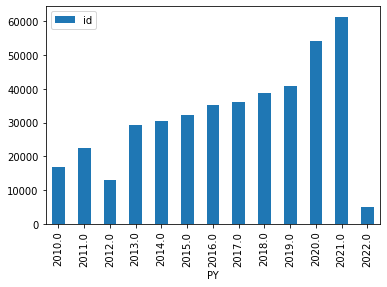

In [34]:
s_queries = [10327, 10380, 8332,8420,8441]
qs = Query.objects.filter(pk__in=s_queries)
dids = set(Doc.objects.filter(query__in=qs).values_list('pk',flat=True))
bypy = pd.DataFrame.from_dict(Doc.objects.filter(id__in=dids).values('id','PY'))
bypy[bypy['PY']>=2010].groupby('PY').count().plot.bar()

In [ ]:
wos_queries = [9591,10326,8318,10438,10448,10448,10450]
qs = Query.objects.filter(pk__in=wos_queries)
dids = set(Doc.objects.filter(query__in=qs).values_list('pk',flat=True))
bypy = pd.DataFrame.from_dict(Doc.objects.filter(id__in=dids).values('id','PY'))
counts = bypy[(bypy['PY']>=2010) & (bypy['PY']<2025)].groupby('PY').count()
counts.plot.bar()
counts

In [7]:
q = Query.objects.get(pk=10438)
q.doc_set.filter(PY=2020).count()

35184

In [8]:
q = Query.objects.get(pk=10448)
q.doc_set.filter(PY=2020).count()

51635

In [ ]:
medline_queries = [9591,10326,8318,10393]
qs = Query.objects.filter(pk__in=wos_queries)
dids = set(Doc.objects.filter(query__in=qs).values_list('pk',flat=True))
bypy = pd.DataFrame.from_dict(Doc.objects.filter(id__in=dids).values('id','PY'))
bypy[(bypy['PY']>=2010) & (bypy['PY']<2020)].groupby('PY').count().plot.bar()

In [36]:
import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'PY',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    query_id=8318, 
    relevant__gt=0,
    doc__content__iregex='\w'
)
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

seen_df = gdf
ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)
print(seen_df.shape)
seen_df.head()

(3240, 8)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen
0,282602,Background: Among the many challenges faced by...,Health coping strategies of the people vulnera...,2013.0,Health coping strategies; Choice of care; Unqu...,"[Public, Environmental & Occupational Health]",1.0,1.0
1,773200,The projected rise in food-related greenhouse ...,Mitigation potential and global health impacts...,2017.0,None,[Environmental Sciences; Environmental Studies...,1.0,1.0
2,3446429,Background: Dengue fever control in the tropic...,Spatial and temporal variation of dengue incid...,2019.0,Dengue; Bali; Spatial analysis; Conditional au...,"[Public, Environmental & Occupational Health; ...",1.0,1.0
3,1672609,Vector-borne infectious diseases continue to b...,Gene drives as a response to infection and res...,2019.0,CRISPR; gene drive; gene editing; vector-borne...,[Infectious Diseases; Pharmacology & Pharmacy],0.0,1.0
4,3393270,A chronic symptomatic acromioclavicular joint ...,Arthroscopically assisted stabilization of chr...,2013.0,Chronic acromioclavicular joint dislocation; A...,[Orthopedics; Surgery],0.0,1.0


In [37]:
q = Query.objects.get(pk=8318)
p = q.project

dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=seen_df['id'],category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
print(dudf_wide.shape)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: mode_na(x)).reset_index()
dudf_wide_r = dudf_wide.reset_index()
dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).head()
print(gudf.shape)
gudf.tail()

(1189, 3)
(1022, 4)


cname,doc__id,1 - Adaptation,1 - Impact,1 - Mitigation
1017,3545401,0.0,1.0,0.0
1018,3545881,0.0,1.0,1.0
1019,3546196,0.0,1.0,0.0
1020,3546265,0.0,1.0,0.0
1021,3546804,0.0,1.0,0.0


In [38]:
seen_df = pd.merge(seen_df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)
print(seen_df.shape)
seen_df.head()

seen_df.to_csv('data/0a_labelled_documents.csv',index=False)

(3240, 11)


In [48]:

qids = [
    10366, # MEDLINE UPDATE
    10393, # MEDLINE BACKDATE
    10327, # SCOPUS UPDATE
    10380, # SOPUS BACKDATE
    10326, # WOS UPDATE 2
    9591, # WOS UPDATE 
    10450, # WOS 2 retry
    10448, # WOS 2020 retry,
    8510, # LPH ALL,

]
qs = Query.objects.filter(pk__in=qids)
dids = set(Doc.objects.filter(query__in=qs).values_list('pk',flat=True))

unseen_docs = Doc.objects.filter(
    id__in=dids - set(seen_df['id']),
    content__iregex='\w',
) 

columns = [
    'id',
    'content',
    'title',
    'PY',
    'wosarticle__dt',
    'tslug',
    'UT__UT'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df.head()

,id,content,title,PY,wosarticle__dt,tslug,UT__UT
0,10548,Background: The effect of temperature on insec...,Effects of Fluctuating Daily Temperatures at C...,2013.0,Article,effectsoffluctuatingdailytemperaturesatcritica...,WOS:000318679900094
1,10677,A change from planktonic to benthic primary pr...,Permanent salt evaporation ponds in a semi-ari...,2013.0,Article,permanentsaltevaporationpondsinasemiaridmedite...,WOS:000319248300003
2,13270,Volatile organic compound (VOC) emissions from...,Online analysis of volatile organic compound e...,2004.0,Article,onlineanalysisofvolatileorganiccompoundemissio...,WOS:000222712700001
3,14606,Objectives To investigate whether a sudden tem...,Temperature variation between neighboring days...,2014.0,Article,temperaturevariationbetweenneighboringdaysandm...,WOS:000345387400006
4,14723,"Background, aims, and scope In this study, we ...",Life cycle inventory analysis on Bio-DME and/o...,2009.0,Article,lifecycleinventoryanalysisonbiodmeandorbiomeoh...,WOS:000271202500004


In [75]:
print(unseen_df.shape)
dups = unseen_df[unseen_df.duplicated("tslug", keep=False)]
dups['WoS'] = dups['UT__UT'].str.match("^WOS:")
print(dups.shape)
dups.head()

(907745, 7)
(69517, 8)


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,content,title,PY,wosarticle__dt,tslug,UT__UT,WoS
21438,277030,We have designed and offered a comprehensive a...,None,2013.0,Article,None,2-s2.0-84884270685,False
21457,323248,Among the different packages of bio-fertilizer...,Development of suitable package using bio-fert...,2016.0,Article,developmentofsuitablepackageusingbiofertilizer...,2-s2.0-84964668130,False
21503,408966,Global demand for clean water supplies is on t...,Assessment of residential rainwater harvesting...,2013.0,JOUR,assessmentofresidentialrainwaterharvestingeffi...,2-s2.0-84874635468,False
21549,484702,Carbon emissions have greatly increased over t...,The influence of natural gas in a four-stroke ...,2011.0,JOUR,theinfluenceofnaturalgasinafourstrokeengine,2-s2.0-84856405363,False
21560,505233,'Children of Our Future' was a short essay pub...,"'Children of Our Future': climate, degeneratio...",2016.0,Article,childrenofourfutureclimatedegenerationandeduca...,WOS:000372445100005,True


In [76]:
print(unseen_df.shape)
for i, t in enumerate(dups['tslug'].unique()):
    if t is not None:
        rows = dups[dups['tslug']==t]
        try:
            keep_id = rows[rows['WoS']==True]['id'].values[0]
        except:
            keep_id = rows['id'].values[0]
        throw_index = rows[rows['id']!=keep_id].index
        unseen_df = unseen_df.drop(index=throw_index)

        if i % 1000==0:
            print(unseen_df.shape)
        

(907745, 7)
(906742, 7)
(905715, 7)
(904710, 7)
(903700, 7)
(902674, 7)
(901662, 7)
(900651, 7)
(899630, 7)
(898605, 7)
(897596, 7)
(896592, 7)
(895582, 7)
(894573, 7)
(893564, 7)
(892555, 7)
(891544, 7)
(890531, 7)
(889519, 7)
(888511, 7)
(887503, 7)
(886498, 7)
(885491, 7)
(884487, 7)
(883479, 7)
(882469, 7)
(881461, 7)
(880460, 7)
(879457, 7)
(878453, 7)
(877451, 7)
(876449, 7)
(875447, 7)
(874444, 7)
(873443, 7)


In [77]:
unseen_df = unseen_df[columns]
unseen_df = unseen_df[unseen_df['wosarticle__dt'].isin(["Article","Review"])]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

unseen_df.to_csv('data/0b_unlabelled_documents.csv',index=False)

(696285, 9)


In [7]:
# unseen_docs = Doc.objects.filter(
#     id__in=dids,
#     content__iregex='\w',
# ) 

# columns = [
#     'id',
#     'content',
#     'title',
#     'PY',
#     'wosarticle__dt'
# ]

# unseen_docs = unseen_docs.exclude(pk__in=seen_df['id']).distinct('id')

# unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
# unseen_df = unseen_df[columns]
# unseen_df = unseen_df[unseen_df['wosarticle__dt'].isin(["Article","Review"])]
# unseen_df['relevant'] = 0
# unseen_df['seen'] = 0

# print(unseen_df.shape)
# unseen_df.head()

# unseen_df.to_csv('data/0b_unlabelled_documents.csv',index=False)

(587499, 7)


<BarContainer object of 27 artists>

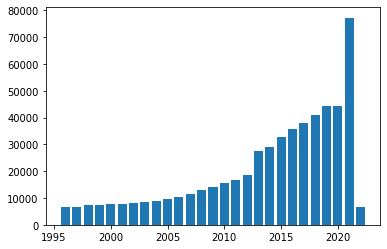

In [16]:
pysums = unseen_df.groupby('PY')['id'].count()
fig, ax = plt.subplots()

pysums = pysums[pysums.index > 1995]

ax.bar(pysums.index, pysums)

In [14]:
pysums.index

Float64Index([1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1964.0, 1966.0,
              1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0,
              1975.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0,
              1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0,
              1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0,
              2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0,
              2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0,
              2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0],
             dtype='float64', name='PY')